# CSE-CIC-IDS 2018 BOTNET ATTACK ON 02/03/2018

## License
You may redistribute, republish, and mirror the CSE-CIC-IDS2018 dataset in any form. However, any use or redistribution of the data must include a citation to the CSE-CIC-IDS2018 dataset and [a link to this page](https://registry.opendata.aws/cse-cic-ids2018/) in AWS.

Source to [Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/ids-2018.html)

## IMPORT LIBRARY/PACKAGES

In [1]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import missingno as msno
import graphviz
import pydot
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

CPU times: total: 6.25 s
Wall time: 59.2 s


Check if Tensorflow detects GPU

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LOADING DATASET IN PANDAS

Loading the csv file and also change a column datatype to the correct value

In [4]:
%%time

# csv file location
path = "Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
parser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S')
network_data = pd.read_csv(path, 
                           parse_dates=['Timestamp'], 
                           date_parser=parser)

CPU times: total: 51.9 s
Wall time: 52.9 s


Timestamp column within the dataset is broken. It does not differentiate between AM and PM. This piece of code will fix the wrong timerange to it's correct AM/PM value.

In [4]:
condition2 = (network_data["Timestamp"].between("2018-03-02 01:00:00", "2018-03-02 07:47:37"))
x = network_data.loc[condition2].Timestamp + timedelta(hours=12)
network_data.loc[condition2,'Timestamp'] = x

print(network_data['Timestamp'].min())
print(network_data['Timestamp'].max())

2018-03-02 08:46:33
2018-03-02 17:30:18


## PRELIMINARY DATA INVESTIGATION

View dataset columns

In [5]:
network_data.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

View datatypes

In [6]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Dst Port           1048575 non-null  int64         
 1   Protocol           1048575 non-null  int64         
 2   Timestamp          1048575 non-null  datetime64[ns]
 3   Flow Duration      1048575 non-null  int64         
 4   Tot Fwd Pkts       1048575 non-null  int64         
 5   Tot Bwd Pkts       1048575 non-null  int64         
 6   TotLen Fwd Pkts    1048575 non-null  int64         
 7   TotLen Bwd Pkts    1048575 non-null  float64       
 8   Fwd Pkt Len Max    1048575 non-null  int64         
 9   Fwd Pkt Len Min    1048575 non-null  int64         
 10  Fwd Pkt Len Mean   1048575 non-null  float64       
 11  Fwd Pkt Len Std    1048575 non-null  float64       
 12  Bwd Pkt Len Max    1048575 non-null  int64         
 13  Bwd Pkt Len Min    1048575 

Check the number of rows and columns

In [7]:
print('Number of Rows (Samples): %s' % str((network_data.shape[0])))
print('Number of Columns (Features): %s' % str((network_data.shape[1])))

Number of Rows (Samples): 1048575
Number of Columns (Features): 80


View first top 2 rows and last 2 rows

In [8]:
overview = [network_data.head(2), network_data.tail(2)]
result = pd.concat(overview)
result

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,2018-03-02 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,2018-03-02 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1048573,3389,6,2018-03-02 14:08:29,3998435,14,8,1459,1731.0,741,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1048574,3389,6,2018-03-02 14:08:33,3972651,14,8,1439,1731.0,725,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


## FEATURE DESCRIPTION
| Feature Name       | Description                                                                                      |
| ------------------ | ------------------------------------------------------------------------------------------------ |
|  |
| fl\_dur            | Flow duration                                                                                    |
| tot\_fw\_pk        | Total packets in the forward direction                                                           |
| tot\_bw\_pk        | Total packets in the backward direction                                                          |
| tot\_l\_fw\_pkt    | Total size of packet in forward direction                                                        |
| fw\_pkt\_l\_max    | Maximum size of packet in forward direction                                                      |
| fw\_pkt\_l\_min    | Minimum size of packet in forward direction                                                      |
| fw\_pkt\_l\_avg    | Average size of packet in forward direction                                                      |
| fw\_pkt\_l\_std    | Standard deviation size of packet in forward direction                                           |
| Bw\_pkt\_l\_max    | Maximum size of packet in backward direction                                                     |
| Bw\_pkt\_l\_min    | Minimum size of packet in backward direction                                                     |
| Bw\_pkt\_l\_avg    | Mean size of packet in backward direction                                                        |
| Bw\_pkt\_l\_std    | Standard deviation size of packet in backward direction                                          |
| fl\_byt\_s         | flow byte rate that is number of packets transferred per second                                  |
| fl\_pkt\_s         | flow packets rate that is number of packets transferred per second                               |
| fl\_iat\_avg       | Average time between two flows                                                                   |
| fl\_iat\_std       | Standard deviation time two flows                                                                |
| fl\_iat\_max       | Maximum time between two flows                                                                   |
| fl\_iat\_min       | Minimum time between two flows                                                                   |
| fw\_iat\_tot       | Total time between two packets sent in the forward direction                                     |
| fw\_iat\_avg       | Mean time between two packets sent in the forward direction                                      |
| fw\_iat\_std       | Standard deviation time between two packets sent in the forward direction                        |
| fw\_iat\_max       | Maximum time between two packets sent in the forward direction                                   |
| fw\_iat\_min       | Minimum time between two packets sent in the forward direction                                   |
| bw\_iat\_tot       | Total time between two packets sent in the backward direction                                    |
| bw\_iat\_avg       | Mean time between two packets sent in the backward direction                                     |
| bw\_iat\_std       | Standard deviation time between two packets sent in the backward direction                       |
| bw\_iat\_max       | Maximum time between two packets sent in the backward direction                                  |
| bw\_iat\_min       | Minimum time between two packets sent in the backward direction                                  |
| fw\_psh\_flag      | Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP)  |
| bw\_psh\_flag      | Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP) |
| fw\_urg\_flag      | Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP)  |
| bw\_urg\_flag      | Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP) |
| fw\_hdr\_len       | Total bytes used for headers in the forward direction                                            |
| bw\_hdr\_len       | Total bytes used for headers in the forward direction                                            |
| fw\_pkt\_s         | Number of forward packets per second                                                             |
| bw\_pkt\_s         | Number of backward packets per second                                                            |
| pkt\_len\_min      | Minimum length of a flow                                                                         |
| pkt\_len\_max      | Maximum length of a flow                                                                         |
| pkt\_len\_avg      | Mean length of a flow                                                                            |
| pkt\_len\_std      | Standard deviation length of a flow                                                              |
| pkt\_len\_va       | Minimum inter-arrival time of packet                                                             |
| fin\_cnt           | Number of packets with FIN                                                                       |
| syn\_cnt           | Number of packets with SYN                                                                       |
| rst\_cnt           | Number of packets with RST                                                                       |
| pst\_cnt           | Number of packets with PUSH                                                                      |
| ack\_cnt           | Number of packets with ACK                                                                       |
| urg\_cnt           | Number of packets with URG                                                                       |
| cwe\_cnt           | Number of packets with CWE                                                                       |
| ece\_cnt           | Number of packets with ECE                                                                       |
| down\_up\_ratio    | Download and upload ratio                                                                        |
| pkt\_size\_avg     | Average size of packet                                                                           |
| fw\_seg\_avg       | Average size observed in the forward direction                                                   |
| bw\_seg\_avg       | Average size observed in the backward direction                                                  |
| fw\_byt\_blk\_avg  | Average number of bytes bulk rate in the forward direction                                       |
| fw\_pkt\_blk\_avg  | Average number of packets bulk rate in the forward direction                                     |
| fw\_blk\_rate\_avg | Average number of bulk rate in the forward direction                                             |
| bw\_byt\_blk\_avg  | Average number of bytes bulk rate in the backward direction                                      |
| bw\_pkt\_blk\_avg  | Average number of packets bulk rate in the backward direction                                    |
| bw\_blk\_rate\_avg | Average number of bulk rate in the backward direction                                            |
| subfl\_fw\_pk      | The average number of packets in a sub flow in the forward direction                             |
| subfl\_fw\_byt     | The average number of bytes in a sub flow in the forward direction                               |
| subfl\_bw\_pkt     | The average number of packets in a sub flow in the backward direction                            |
| subfl\_bw\_byt     | The average number of bytes in a sub flow in the backward direction                              |
| fw\_win\_byt       | Number of bytes sent in initial window in the forward direction                                  |
| bw\_win\_byt       | \# of bytes sent in initial window in the backward direction                                     |
| Fw\_act\_pkt       | \# of packets with at least 1 byte of TCP data payload in the forward direction                  |
| fw\_seg\_min       | Minimum segment size observed in the forward direction                                           |
| atv\_avg           | Mean time a flow was active before becoming idle                                                 |
| atv\_std           | Standard deviation time a flow was active before becoming idle                                   |
| atv\_max           | Maximum time a flow was active before becoming idle                                              |
| atv\_min           | Minimum time a flow was active before becoming idle                                              |
| idl\_avg           | Mean time a flow was idle before becoming active                                                 |
| idl\_std           | Standard deviation time a flow was idle before becoming active                                   |
| idl\_max           | Maximum time a flow was idle before becoming active                                              |
| idl\_min           | Minimum time a flow was idle before becoming active                                              |

## EDA (EXPLORATORY DATA ANALYSIS)
For making a proper undertanding of dataset we are using, we will perform a bief EDA (Exploratory Data Analysis). The EDA is sub-divided into:

-    Data Visuals
-    Data Understanding
-    Data Analysis

The graph below shows the amount of harmfull and harmless packages

In [9]:
network_data['Label'].value_counts()

Benign    762384
Bot       286191
Name: Label, dtype: int64

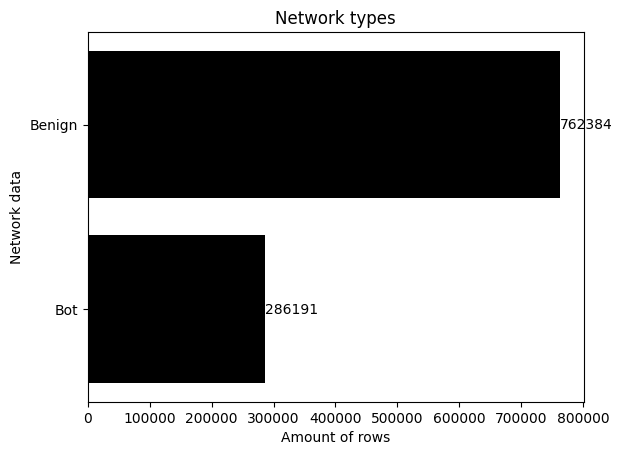

CPU times: total: 938 ms
Wall time: 1.38 s


In [10]:
%%time

ax = sns.countplot(data=network_data["Label"], 
                  y=network_data["Label"], 
                  color='black')
ax.bar_label(ax.containers[0])

plt.xlabel("Amount of rows")
plt.ylabel("Network data")
plt.title("Network types")
plt.show()

From the graphs, we came to know that:
- There is 1 attack, Botnet attack, present in this dataset
- There are 762.384 rows containing benign packages
- There are 286.191 rows containing a botnet attack
- 27% of all network data is part of a botnet attack
- 73% of all network data is benign

The graph below shows when the Botnet attack took place during the day

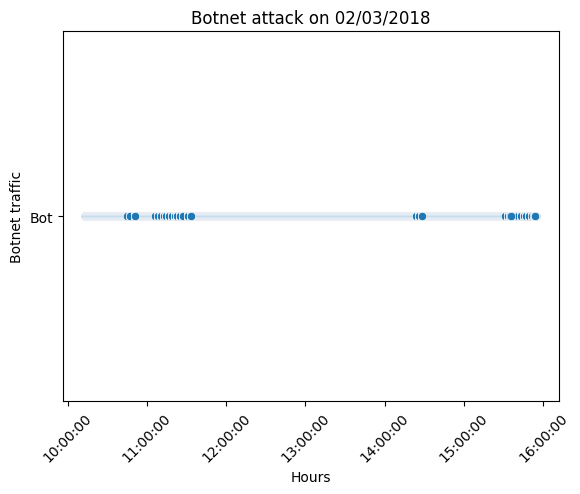

CPU times: total: 828 ms
Wall time: 1 s


In [11]:
%%time
data = network_data[(network_data['Label'] == 'Bot')]

# seaborn scatterplot
ax = sns.scatterplot(data=data, 
                     x=data['Timestamp'], 
                     y=data['Label'])

# change ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.xlabel("Hours")
plt.ylabel("Botnet traffic")
plt.title("Botnet attack on 02/03/2018")

plt.show()

From the graphs, we came to know that:
- An attack took place at on 02-03-2018 at 10:11 to 11:34
- An attack took place at on 02-03-201 at 14:24 to 15:55

Zeus, which is a Trojan horse malware package that runs on versions of Microsoft Windows. While it can be used to carry out many malicious and criminal tasks, it is often used to steal banking information by man-in-the-browser keystroke logging and form grabbing. It is also used to install the Crypto-Locker ransomware. Zeus is spread mainly through drive-by downloads and phishing schemes. Also, as a complement Ares botnet is used which is an open source botnet and has the following capabilities:

- remote cmd.exe shell
- persistence
- file upload/download
- screenshot
- key logging

The scatterplot below shows the file upload/download characteristics of a botnet attack

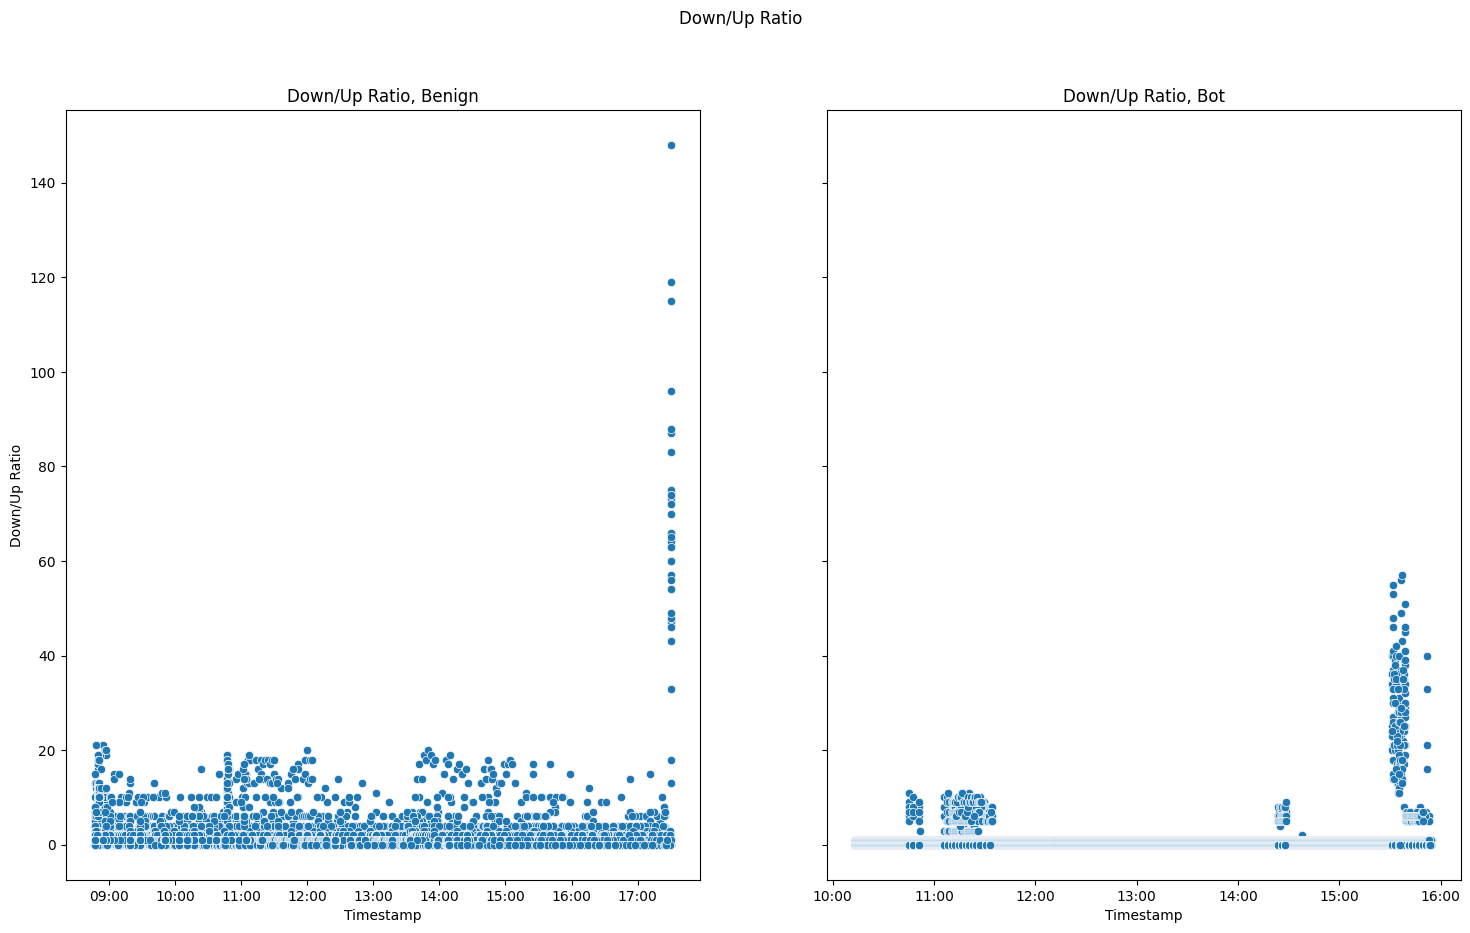

CPU times: total: 2.69 s
Wall time: 2.78 s


In [12]:
%%time

condition1 = network_data[network_data['Label'] == 'Benign']
condition2 = network_data[network_data['Label'] == 'Bot']

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)
fig.suptitle('Down/Up Ratio')

ax0 = sns.scatterplot(ax=axes[0], x=condition1["Timestamp"], y=condition1["Down/Up Ratio"])
axes[0].set_title('Down/Up Ratio, Benign')
ax1 = sns.scatterplot(ax=axes[1], x=condition2["Timestamp"], y=condition2["Down/Up Ratio"])
axes[1].set_title('Down/Up Ratio, Bot')

ax0.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

From the graphs, we came to know that:
- There is a lot of harmless download activity at 17:30 hour
- There is a lot of harmful download activity at around 15:45 hour

The boxplot below shows the Down/Up ratio with the focus on outliers

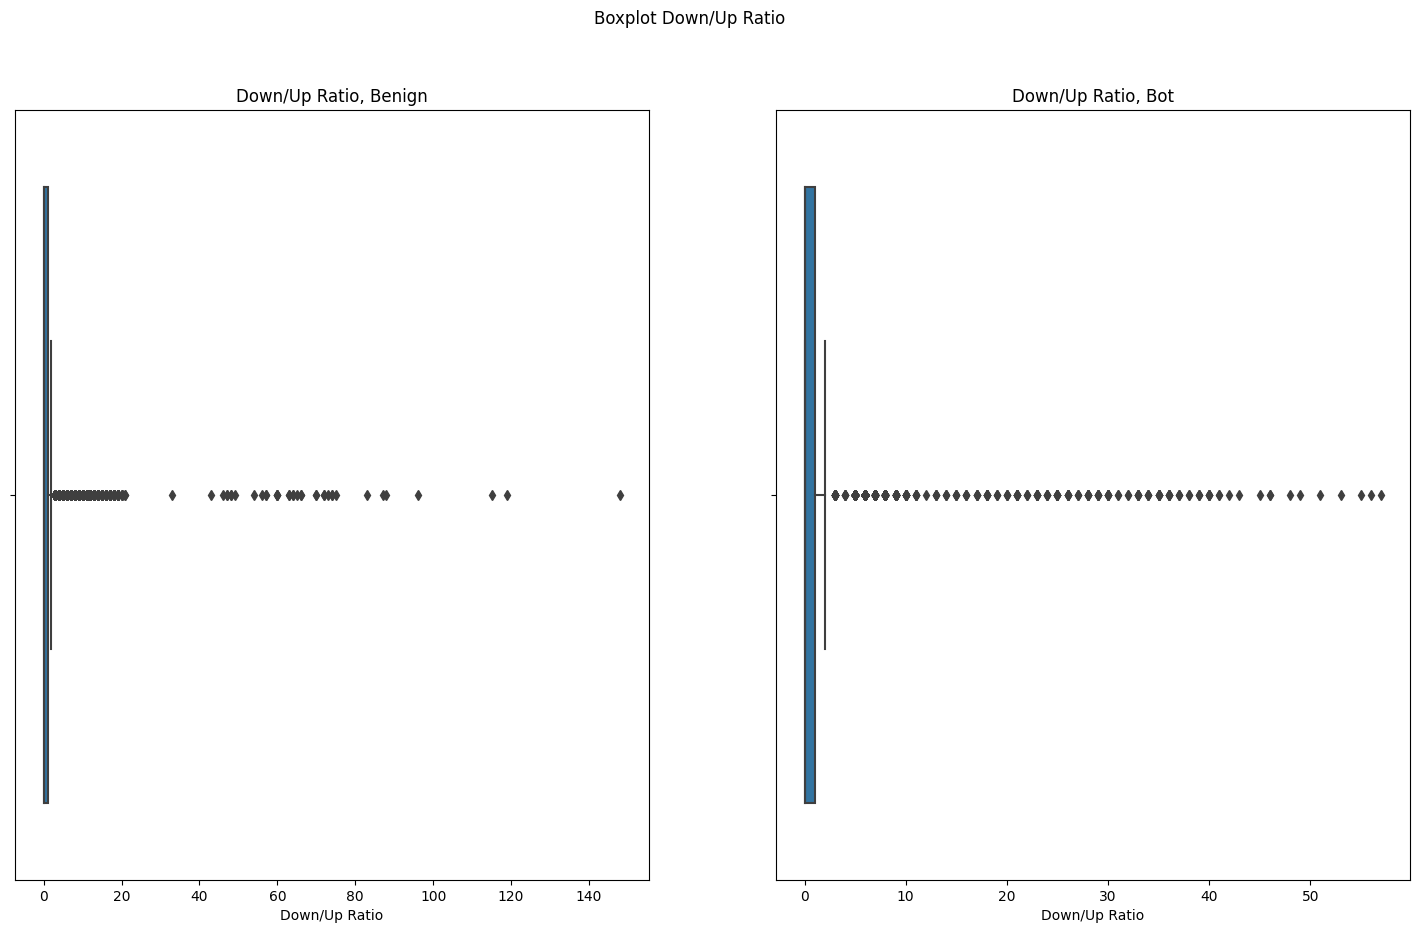

CPU times: total: 547 ms
Wall time: 575 ms


In [13]:
%%time

condition1 = network_data[network_data['Label'] == 'Benign']
condition2 = network_data[network_data['Label'] == 'Bot']

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)
fig.suptitle('Boxplot Down/Up Ratio')

ax0 = sns.boxplot(ax=axes[0], x=condition1["Down/Up Ratio"])
axes[0].set_title('Down/Up Ratio, Benign')
ax1 = sns.boxplot(ax=axes[1], x=condition2["Down/Up Ratio"])
axes[1].set_title('Down/Up Ratio, Bot')

plt.show()

From the graphs, we came to know that:
- There are a lot of ouliers visible. It might say something about peak usage in the network but that is just speculation

The graph below shows the total amount of packages sent in the forward and backwards direction

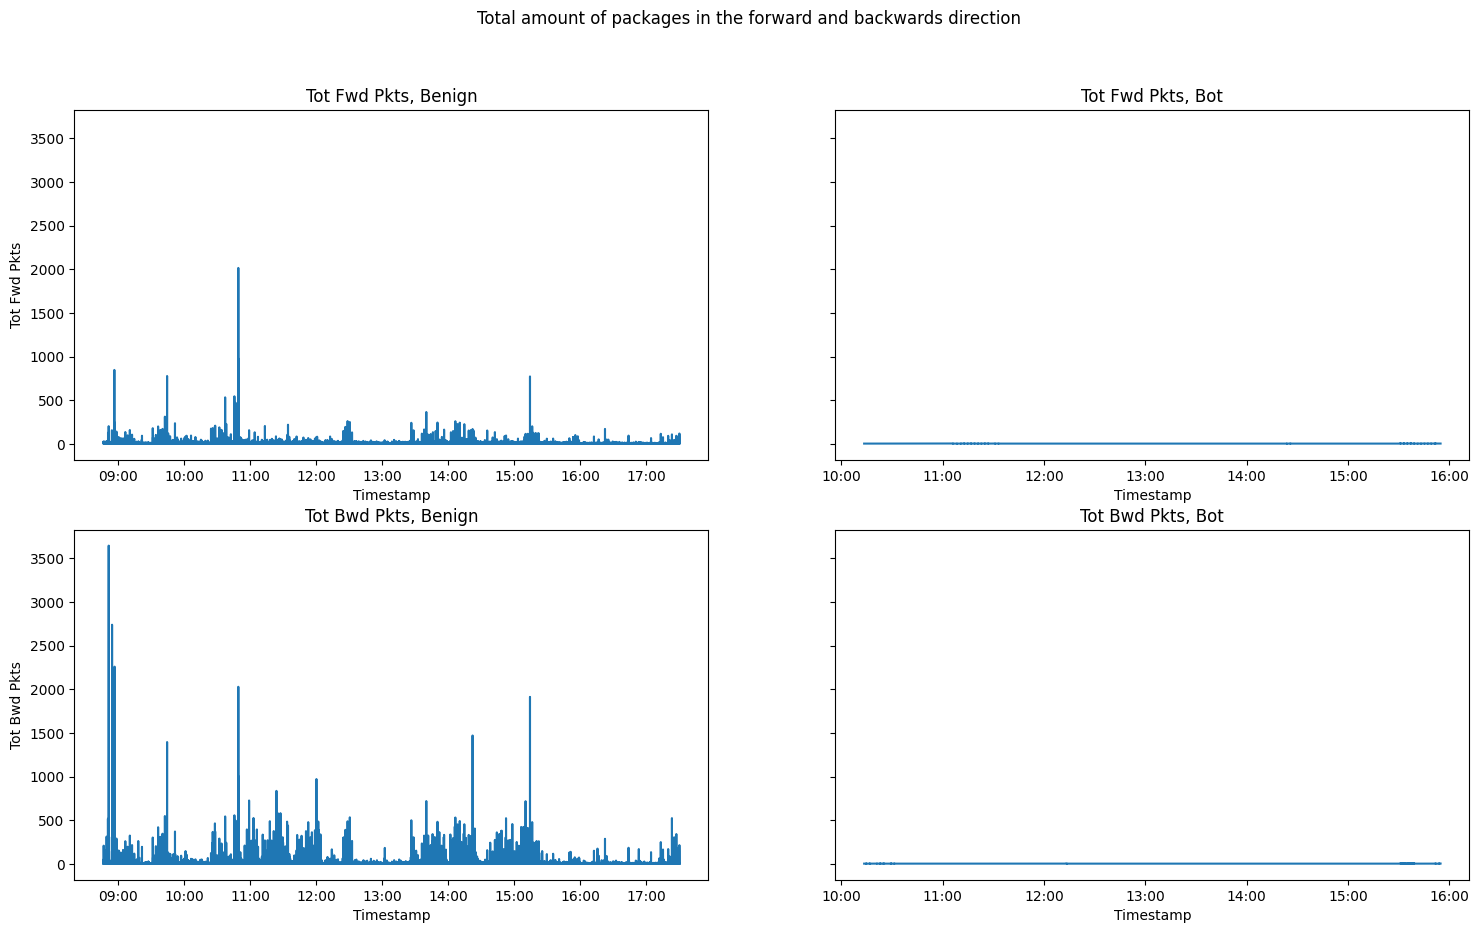

CPU times: total: 42.1 s
Wall time: 42.9 s


In [14]:
%%time

condition1 = network_data[network_data['Label'] == 'Benign']
condition2 = network_data[network_data['Label'] == 'Bot']

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True)
fig.suptitle('Total amount of packages in the forward and backwards direction')

ax0 = sns.lineplot(ax=axes[0,0], x=condition1["Timestamp"], y=condition1["Tot Fwd Pkts"], errorbar=None)
axes[0,0].set_title('Tot Fwd Pkts, Benign')
ax1 = sns.lineplot(ax=axes[0,1], x=condition2["Timestamp"], y=condition2["Tot Fwd Pkts"], errorbar=None)
axes[0,1].set_title('Tot Fwd Pkts, Bot')
ax2 = sns.lineplot(ax=axes[1,0], x=condition1["Timestamp"], y=condition1["Tot Bwd Pkts"], errorbar=None)
axes[1,0].set_title('Tot Bwd Pkts, Benign')
ax3 = sns.lineplot(ax=axes[1,1], x=condition2["Timestamp"], y=condition2["Tot Bwd Pkts"], errorbar=None)
axes[1,1].set_title('Tot Bwd Pkts, Bot')

ax0.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

From the graphs, we came to know that:
- There is visible botnet activity on the tot fwd pkts feature but it does not shows high amount of number compared to the harmless network packages

The boxplot below shows the Tot Fwd Pkts and Tot Bwd Pkts with the focus on outliers

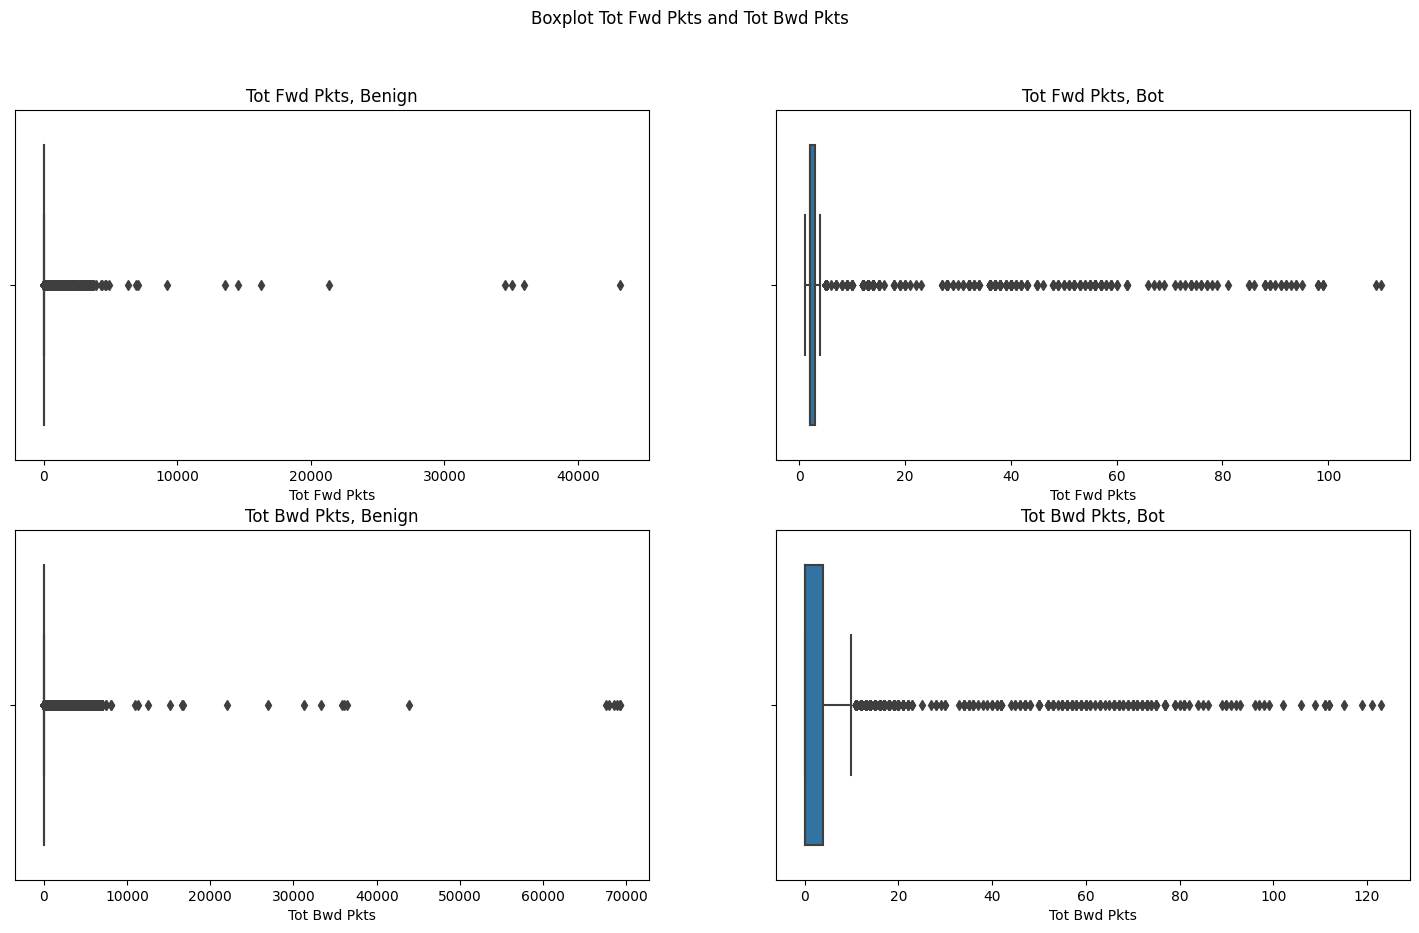

CPU times: total: 828 ms
Wall time: 849 ms


In [15]:
%%time

condition1 = network_data[network_data['Label'] == 'Benign']
condition2 = network_data[network_data['Label'] == 'Bot']

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True)
fig.suptitle('Boxplot Tot Fwd Pkts and Tot Bwd Pkts')

ax0 = sns.boxplot(ax=axes[0,0], x=condition1["Tot Fwd Pkts"])
axes[0,0].set_title('Tot Fwd Pkts, Benign')
ax1 = sns.boxplot(ax=axes[0,1], x=condition2["Tot Fwd Pkts"])
axes[0,1].set_title('Tot Fwd Pkts, Bot')
ax1 = sns.boxplot(ax=axes[1,0], x=condition1["Tot Bwd Pkts"])
axes[1,0].set_title('Tot Bwd Pkts, Benign')
ax1 = sns.boxplot(ax=axes[1,1], x=condition2["Tot Bwd Pkts"])
axes[1,1].set_title('Tot Bwd Pkts, Bot')

plt.show()

From the graphs, we came to know that:
- harmless packages have increased tot number of packages in both direction compared to the harmful packages

Correlation matrix to see if there is a correlation between some features

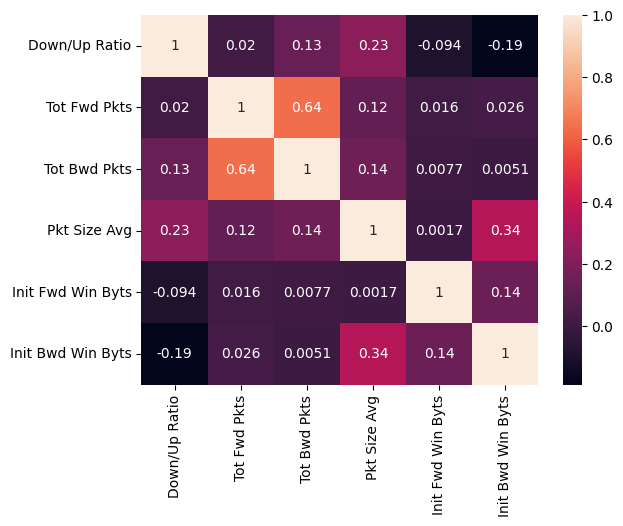

In [16]:
df = pd.DataFrame(network_data[['Down/Up Ratio','Tot Fwd Pkts','Tot Bwd Pkts','Pkt Size Avg','Init Fwd Win Byts','Init Bwd Win Byts']])
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

The output below shows what destination ports are used the most and which ones are used the least.

In [17]:
condition = (network_data[network_data['Dst Port'] != 0])
mask = condition['Dst Port']

#network_data['Dst Port'].value_counts()
print('Most used ports \n',network_data['Dst Port'].nlargest(n=5),"\n")
print('Least used ports \n',mask.nsmallest(n=5))

#Top 5 porten
#top 10 porten

Most used ports 
 757589    65534
570001    65532
844988    65532
803553    65529
807969    65528
Name: Dst Port, dtype: int64 

Least used ports 
 56044     21
88105     21
316246    21
317236    21
318716    21
Name: Dst Port, dtype: int64


## DATA CLEANING

Convert values in column Label with datatype object to datatype integer.

In [5]:
# convert string to either be 0 or 1
network_data['Label'].replace({'Benign': '0', 'Bot': '1'}, inplace=True)
network_data['Label'] = pd.to_numeric(network_data['Label'])
network_data.head(2)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,2018-03-02 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,49684,6,2018-03-02 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Visualize missing data with missingno library

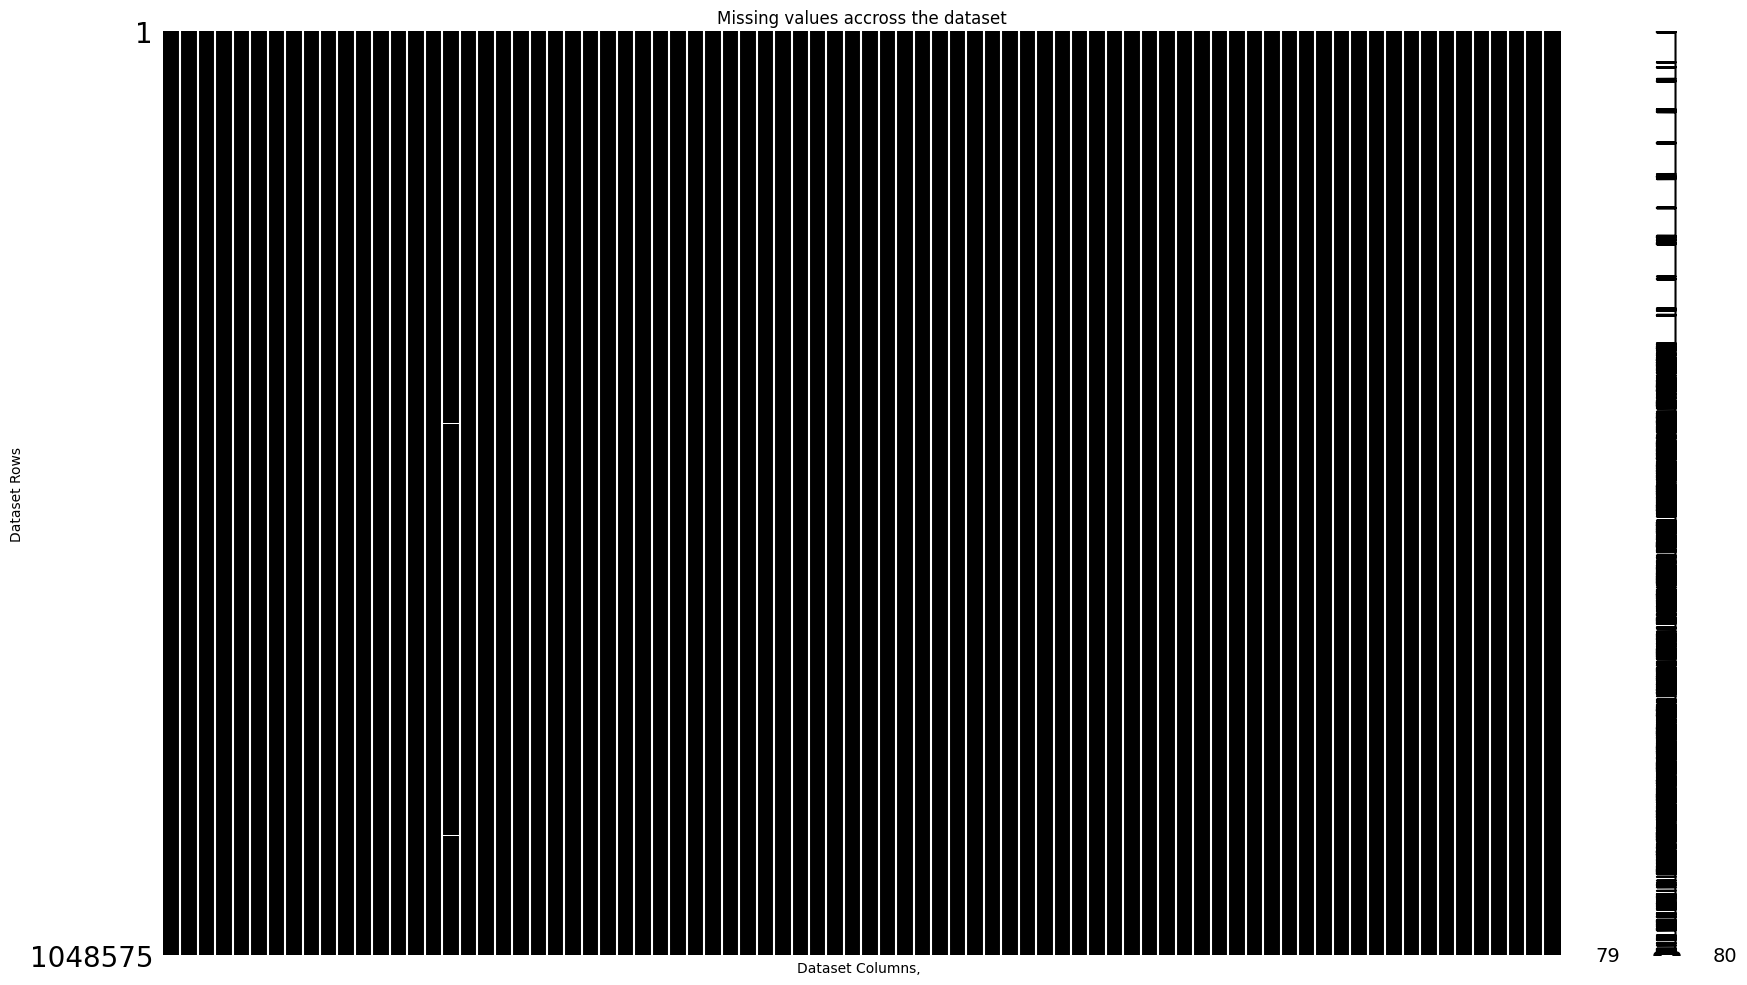

In [6]:
# white dashes represent empty data
msno.matrix(network_data, 
            color=(0.0, 0.0, 0.0),
            figsize=(20,12))

plt.title('Missing values accross the dataset')
plt.xlabel('Dataset Columns, ')
plt.ylabel('Dataset Rows')

plt.show()

removing NaN (not a number) values

In [7]:
nan_values = network_data.isna().any(axis=1).sum()
print (nan_values,"rows with at least one NaN removed")
network_data.dropna(inplace=True)

2558 rows with at least one NaN removed


removing duplicates

In [8]:
duplicates = network_data.duplicated().sum
print (duplicates,"duplicates removed")
network_data.drop_duplicates()

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0          False
1          False
2          False
3          False
4          False
           ...  
1048570    False
1048571    False
1048572    False
1048573    False
1048574    False
Length: 1046017, dtype: bool> duplicates removed


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,2018-03-02 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,49684,6,2018-03-02 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,443,6,2018-03-02 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,443,6,2018-03-02 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,443,6,2018-03-02 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,3389,6,2018-03-02 14:08:18,3982183,14,8,1442,1731.0,725,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1048571,3389,6,2018-03-02 14:08:22,3802316,14,8,1440,1731.0,725,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1048572,3389,6,2018-03-02 14:08:25,4004239,14,8,1459,1731.0,741,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1048573,3389,6,2018-03-02 14:08:29,3998435,14,8,1459,1731.0,741,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## DATA PREPARATION

This stage involves the data to split into train & test sets 70/30 ratio. The training data will be used for training our model, and the testing data will be used to check the performance of model on unseen dataset

In [9]:
print(network_data['Label'].value_counts())

0    759826
1    286191
Name: Label, dtype: int64


In [10]:
condition1 = network_data[network_data['Label'] == 0].sample(n=42928)
condition2 = network_data[network_data['Label'] == 1].sample(n=42928)

test_dataset = pd.concat([condition1, condition2])

In [11]:
network_data.drop(condition1.index, inplace = True)
network_data.drop(condition2.index, inplace = True)

condition3 = network_data[network_data['Label'] == 0].sample(n=100166)
condition4 = network_data[network_data['Label'] == 1].sample(n=100166)

train_dataset = pd.concat([condition3, condition4])

In [12]:
print(test_dataset['Label'].value_counts())
print(train_dataset['Label'].value_counts())

0    42928
1    42928
Name: Label, dtype: int64
0    100166
1    100166
Name: Label, dtype: int64


In [13]:
#test_dataset = network_data.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

Keras provides numpy utility library, which provides functions to perform actions on numpy arrays. Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [14]:
y_train = to_categorical(target_train, num_classes=2)
y_test = to_categorical(target_test, num_classes=2)

In [15]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

Making train & test splits

In [16]:
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test

array([[8.0000000e+01, 5.3336040e+06, 4.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.0000000e+01, 5.4765393e+07, 2.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.0000000e+01, 7.7300000e+02, 3.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.0800000e+03, 5.1400000e+02, 2.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.0800000e+03, 5.0400000e+02, 2.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.0800000e+03, 5.0300000e+02, 2.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

View array shape

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200332, 72)
(85856, 72)
(200332, 2)
(85856, 2)


This code reshapes the data for CNN. This converts a 2 dimensional array to a 3 dimensional array to fit the tensor.

In [18]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((200332, 72, 1), (85856, 72, 1))

## CNN-LSTM ALGORITHM

In [2]:
# making the deep learning CNN-LSTM algorithm
model = Sequential()

model.add(Conv1D(filters=64, 
                 kernel_size=6, 
                 activation='relu', 
                 padding='same', 
                 input_shape=(72, 1)))

    
model.add(MaxPooling1D(pool_size=(2), 
                       strides=2, 
                       padding='same'))

model.add(Conv1D(filters=128, 
                 kernel_size=6, 
                 activation='relu', 
                 padding='same', 
                 input_shape=(72, 1)))

model.add(MaxPooling1D(pool_size=(2), 
                       strides=2, 
                       padding='same'))
    
model.add(LSTM(70))
    
## flatten() method is used for converting multi-dimensional array 
## into one dimensional flatten array or say single dimensional array
model.add(Flatten())
    
## dense Layer is simple layer of neurons in which each neuron receives 
## input from all the neurons of previous layer
model.add(Dense(64, 
                activation='relu'))

model.add(Dense(64, 
                activation='relu'))

model.add(Dense(2, 
                activation='softmax'))
   
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 72, 64)            448       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 70)                55720     
                                                                 
 flatten (Flatten)           (None, 70)                0

model visualization

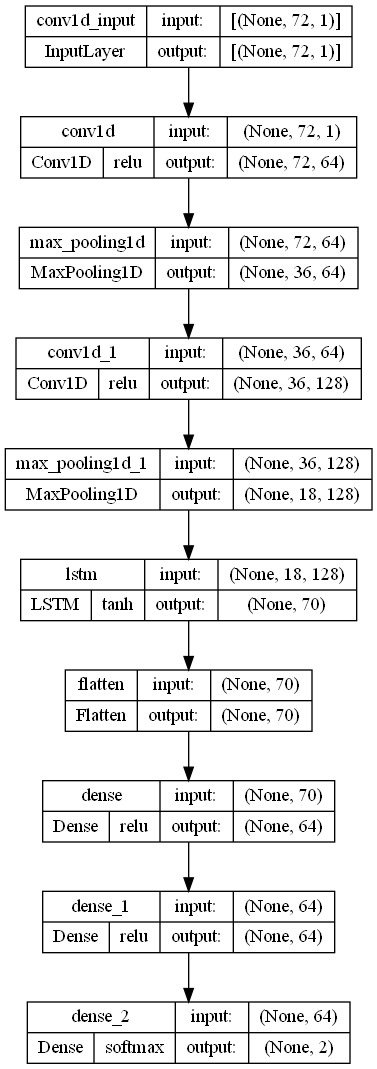

In [3]:
## model visualization
#from keras.utils import plot_model
plot_model(model, 
           to_file="model.png", 
           show_shapes=True, 
           show_dtype=False, 
           show_layer_names=True, 
           rankdir="TB", 
           expand_nested=False, 
           dpi=96, 
           layer_range=None, 
           show_layer_activations=True)

In [20]:
# training dataset
logger = CSVLogger('train_logs.csv',
                   append=True)

his = model.fit(X_train, 
                y_train, 
                epochs=100, 
                batch_size=32, 
                validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/100
6261/6261 [==============================] - 60s 9ms/step - loss: 0.1576 - accuracy: 0.9496 - val_loss: 0.3685 - val_accuracy: 0.8365
Epoch 2/100
6261/6261 [==============================] - 56s 9ms/step - loss: 0.2050 - accuracy: 0.9265 - val_loss: 0.1204 - val_accuracy: 0.9685
Epoch 3/100
6261/6261 [==============================] - 56s 9ms/step - loss: 0.1121 - accuracy: 0.9696 - val_loss: 0.0901 - val_accuracy: 0.9750
Epoch 4/100
6261/6261 [==============================] - 56s 9ms/step - loss: 0.1165 - accuracy: 0.9659 - val_loss: 0.1595 - val_accuracy: 0.9464
Epoch 5/100
6261/6261 [==============================] - 57s 9ms/step - loss: 0.1399 - accuracy: 0.9556 - val_loss: 0.1534 - val_accuracy: 0.9468
Epoch 6/100
6261/6261 [==============================] - 57s 9ms/step - loss: 0.1163 - accuracy: 0.9649 - val_loss: 0.1580 - val_accuracy: 0.9470
Epoch 7/100
6261/6261 [==============================] - 57s 9ms/step - loss: 0.1215 - accuracy: 0.9633 - val_loss: 0.1046 -

Epoch 57/100
6261/6261 [==============================] - 59s 9ms/step - loss: 0.1935 - accuracy: 0.9436 - val_loss: 0.2210 - val_accuracy: 0.9236
Epoch 58/100
6261/6261 [==============================] - 58s 9ms/step - loss: 0.1320 - accuracy: 0.9623 - val_loss: 0.1390 - val_accuracy: 0.9708
Epoch 59/100
6261/6261 [==============================] - 60s 10ms/step - loss: 0.1805 - accuracy: 0.9437 - val_loss: 0.1463 - val_accuracy: 0.9482
Epoch 60/100
6261/6261 [==============================] - 59s 9ms/step - loss: 0.1577 - accuracy: 0.9482 - val_loss: 0.1611 - val_accuracy: 0.9454
Epoch 61/100
6261/6261 [==============================] - 60s 10ms/step - loss: 0.1838 - accuracy: 0.9397 - val_loss: 0.1712 - val_accuracy: 0.9467
Epoch 62/100
6261/6261 [==============================] - 59s 9ms/step - loss: 0.2259 - accuracy: 0.9160 - val_loss: 0.1248 - val_accuracy: 0.9715
Epoch 63/100
6261/6261 [==============================] - 60s 10ms/step - loss: 0.1937 - accuracy: 0.9303 - val_loss

In [21]:
# check the model performance on test data
scores = model.evaluate(X_test, 
                        y_test)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

2683/2683 [==============================] - 10s 4ms/step - loss: 0.0593 - accuracy: 0.9859
accuracy: 98.59%
